In [2]:
from RCGP.rcgp.rcgp import RCGPR
import matplotlib.pyplot as plt 
import numpy as np 

import gpflow as gpf
from RCGP.rcgp.w import IMQ

2025-05-05 07:19:09.236703: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-05 07:19:09.303328: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-05 07:19:09.455944: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-05 07:19:09.455994: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-05 07:19:09.465239: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [3]:
def plot_model(model: gpf.models.GPModel) -> None:
    X, Y = model.data
    opt = gpf.optimizers.Scipy()
    opt.minimize(model.training_loss, model.trainable_variables)
    gpf.utilities.print_summary(model, "notebook")

    Xplot = np.linspace(0.0, len(Y), len(Y))[:, None]

    y_mean, y_var = model.predict_y(Xplot, full_cov=False)
    y_lower = y_mean - 1.96 * np.sqrt(y_var)
    y_upper = y_mean + 1.96 * np.sqrt(y_var)

    _, ax = plt.subplots(nrows=1, ncols=1)
    ax.plot(X, Y, "kx", mew=2)
    (mean_line,) = ax.plot(Xplot, y_mean, "-")
    color = mean_line.get_color()
    ax.plot(Xplot, y_lower, lw=0.1, color=color)
    ax.plot(Xplot, y_upper, lw=0.1, color=color)
    ax.fill_between(
        Xplot[:, 0], y_lower[:, 0], y_upper[:, 0], color=color, alpha=0.1
    )
    plt.xlabel("t")
    plt.ylabel("y")
    plt.title(model.name)
    
    # Also plot the inducing variables if possible:
    iv = getattr(model, "inducing_variable", None)
    if iv is not None:
        ax.scatter(iv.Z, np.zeros_like(iv.Z), marker="^")

### Can we LRT changepoints with this?

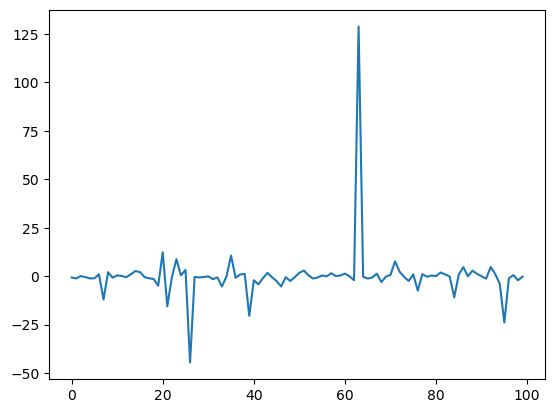

In [4]:
y = np.random.standard_t(1, size=100).reshape(-1, 1)
#y = np.random.normal(0, 0.1, 100)[:,None]
#y[int(len(y)/2):] = y[int(len(y)/2):] + 20
X = np.arange(len(y)).astype(float).reshape(-1, 1)

plt.plot(X, y)
plt.show()

In [5]:
model = RCGPR((X, y), weighting_function=IMQ(C=np.quantile(np.abs(y), 0.7)), kernel=gpf.kernels.RBF())#gpf.kernels.ChangePoints(kernels=[gpf.kernels.RBF() for i in range(2)], locations=[15], steepness=1))

name,class,transform,prior,trainable,shape,dtype,value
RCGPR.kernel.variance,Parameter,Softplus,,True,(),float64,21.4988
RCGPR.kernel.lengthscales,Parameter,Softplus,,True,(),float64,0.12494
RCGPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,15.7496
RCGPR.weighting_function.C,Parameter,Softplus,,True,(),float64,2.7747


<tf.Tensor: shape=(), dtype=float64, numpy=-161.38727259088887>

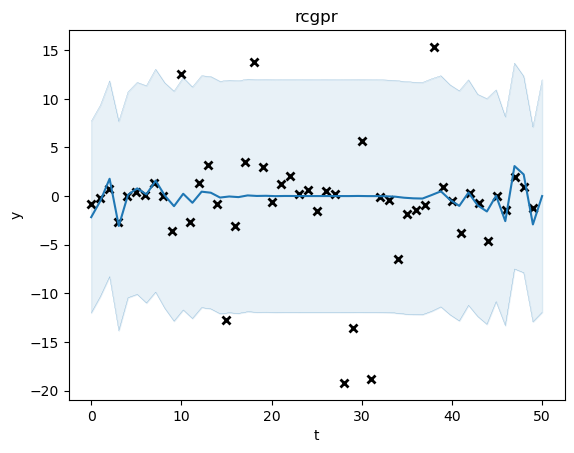

In [6]:
plot_model(model)
model.maximum_log_likelihood_objective()

name,class,transform,prior,trainable,shape,dtype,value
GPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,20.59582
GPR.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,0.50091
GPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1.0
GPR.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,1.0
GPR.kernel.locations,Parameter,Identity,,True,"(1,)",float64,[50.]
GPR.kernel.steepness,Parameter,Softplus,,True,(),float64,100.0
GPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,16.65094


tf.Tensor(-161.2457138184305, shape=(), dtype=float64)


name,class,transform,prior,trainable,shape,dtype,value
SGPR.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,2.88492
SGPR.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,2.82614
SGPR.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1.0
SGPR.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,1.0
SGPR.kernel.locations,Parameter,Identity,,True,"(1,)",float64,[50.]
SGPR.kernel.steepness,Parameter,Softplus,,True,(),float64,100.0
SGPR.likelihood.variance,Parameter,Softplus + Shift,,True,(),float64,34.3592
SGPR.inducing_variable.Z,Parameter,Identity,,True,"(20, 1)",float64,[[15.1823...


<tf.Tensor: shape=(), dtype=float64, numpy=-161.13974880722964>

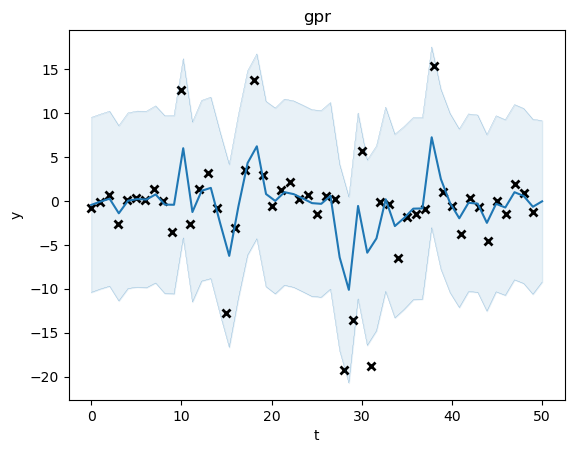

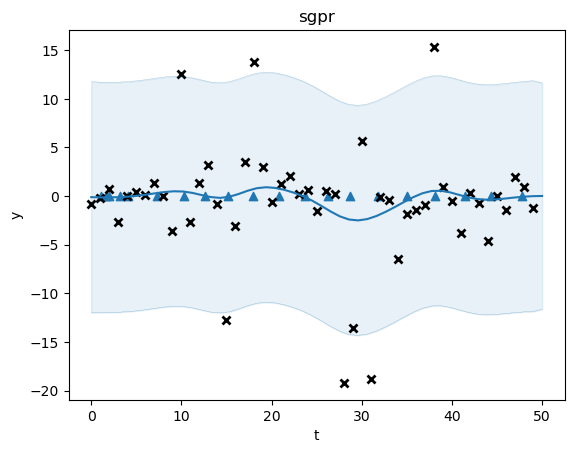

In [7]:
k = gpf.kernels.ChangePoints([gpf.kernels.RBF() for i in range(2)], locations=[50], steepness=100)
k2 = gpf.kernels.ChangePoints([gpf.kernels.RBF() for i in range(2)], locations=[50], steepness=100)
gpr = gpf.models.GPR((X, y), kernel=k)
sgpr = gpf.models.SGPR((X, y), kernel=k2, inducing_variable=np.random.choice(X.flatten(), 20).reshape(-1, 1))

plot_model(gpr)
print(gpr.maximum_log_likelihood_objective())
plot_model(sgpr)
sgpr.maximum_log_likelihood_objective()


name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.0
VGP.kernel.kernels[0].lengthscales,Parameter,Softplus,,True,(),float64,0.01599
VGP.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,0.0
VGP.kernel.kernels[1].lengthscales,Parameter,Softplus,,True,(),float64,1.76727
VGP.kernel.locations,Parameter,Identity,,True,"(1,)",float64,[18.73496]
VGP.kernel.steepness,Parameter,Softplus,,True,"(1,)",float64,[10.00716]
VGP.likelihood.scale,Parameter,Softplus + Shift,,True,(),float64,2.52469
VGP.num_data,Parameter,Identity,,False,(),int32,50
VGP.q_mu,Parameter,Identity,,True,"(50, 1)",float64,[[-2.1e-04...
VGP.q_sqrt,Parameter,FillTriangular,,True,"(1, 50, 50)",float64,"[[[9.99990e-01, 0.00000e+00, 0.00000e+00..."


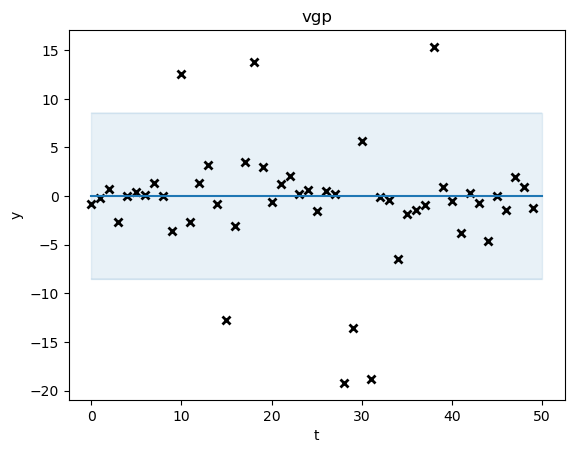

In [8]:
model = gpf.models.VGP(
    (X, y),
    kernel=gpf.kernels.ChangePoints(kernels=[gpf.kernels.RBF() for i in range(2)], locations=[20], steepness=[10]),
    likelihood=gpf.likelihoods.StudentT(),
)

plot_model(model)